In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 64
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicBlock, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out = self.feature(x)
        return out

In [8]:
class Inception(nn.Module):
    def __init__(self, in_channels, out_channel1, temp_channel2, out_channel2, temp_channel3, out_channel3, out_channel4):
        super(Inception, self).__init__()
        self.branch1 = BasicBlock(in_channels=in_channels,
                                  out_channels=out_channel1, kernel_size=1)
        self.branch2 = nn.Sequential(
            BasicBlock(in_channels=in_channels,
                       out_channels=temp_channel2, kernel_size=1),
            BasicBlock(in_channels=temp_channel2,
                       out_channels=out_channel2, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            BasicBlock(in_channels=in_channels,
                       out_channels=temp_channel3, kernel_size=1),
            BasicBlock(in_channels=temp_channel3,
                       out_channels=out_channel3, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicBlock(in_channels=in_channels,
                       out_channels=out_channel4, kernel_size=1),
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

In [9]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.num_classes = num_classes
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        # output[batch, 128, 4, 4]
        self.conv = BasicBlock(in_channels=in_channels,
                               out_channels=128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, self.num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        # N x 2048
        x = self.relu(x)
        x = self.dropout(x)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x

In [10]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, aux_logits=False, init_weights=False):
        super(GoogLeNet, self).__init__()
        # input [batch,3,224,224] -> [batch,64,56,56]
        self.num_classes = num_classes
        self.aux_logits = aux_logits
        self.init_weights = init_weights
        self.conv1 = BasicBlock(
            in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # input [batch,64,56,56] -> [batch,192,28,28]
        self.conv2 = BasicBlock(in_channels=64, out_channels=64, kernel_size=1)
        self.conv3 = BasicBlock(in_channels=64, out_channels=192,
                                kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # input[batch, 192, 28, 28] -> [batch, 480, 14, 14]
        self.inception3a = Inception(in_channels=192, out_channel1=64, temp_channel2=96,
                                     out_channel2=128, temp_channel3=16, out_channel3=32, out_channel4=32)
        self.inception3b = Inception(in_channels=256, out_channel1=128, temp_channel2=128,
                                     out_channel2=192, temp_channel3=32, out_channel3=96, out_channel4=64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # input [batch,480,14,14] -> [batch,832,7,7]
        self.inception4a = Inception(in_channels=480, out_channel1=192, temp_channel2=96,
                                     out_channel2=208, temp_channel3=16, out_channel3=48, out_channel4=64)
        self.inception4b = Inception(in_channels=512, out_channel1=160, temp_channel2=112,
                                     out_channel2=224, temp_channel3=24, out_channel3=64, out_channel4=64)
        self.inception4c = Inception(in_channels=512, out_channel1=128, temp_channel2=128,
                                     out_channel2=256, temp_channel3=24, out_channel3=64, out_channel4=64)
        self.inception4d = Inception(in_channels=512, out_channel1=112, temp_channel2=114,
                                     out_channel2=288, temp_channel3=32, out_channel3=64, out_channel4=64)
        self.inception4e = Inception(in_channels=528, out_channel1=256, temp_channel2=160,
                                     out_channel2=320, temp_channel3=32, out_channel3=128, out_channel4=128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # input [batch,832,7,7] -> [batch,1024,7,7]
        self.inception5a = Inception(in_channels=832, out_channel1=256, temp_channel2=160,
                                     out_channel2=320, temp_channel3=32, out_channel3=128, out_channel4=128)
        self.inception5b = Inception(in_channels=832, out_channel1=384, temp_channel2=192,
                                     out_channel2=384, temp_channel3=48, out_channel3=128, out_channel4=128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)
        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)
        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [11]:
net = GoogLeNet().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
        BasicBlock-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10          [-1, 192, 56, 56]         110,784
      BatchNorm2d-11          [-1, 192, 56, 56]             384
             ReLU-12          [-1, 192, 56, 56]               0
       BasicBlock-13          [-1, 192, 56, 56]               0
        MaxPool2d-14          [-1, 192,

In [14]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [15]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [16]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [17]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [18]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [19]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.391367
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1.763096
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.586172
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.604746
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.576370
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.254192
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.498945
VAL set: Average loss: 0.022530, Accuracy: 4697.0/10000 (47.0%)
Validation loss decreased (inf --> 0.022530).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.467706
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.218500
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.159527
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.295746
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.119213
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.110717
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.189030
VAL set: Average loss: 0.018143, Accuracy: 5757.0/10000 (57.6%)
Validation loss decreased (0.022530 --> 0.018143).  Saving model ...

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.093254
Trai

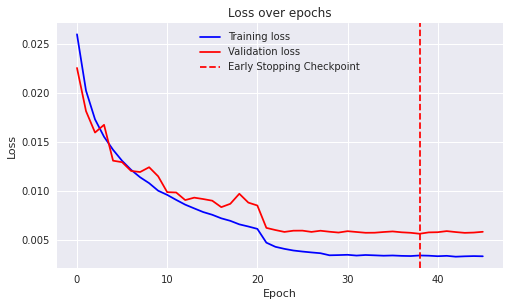

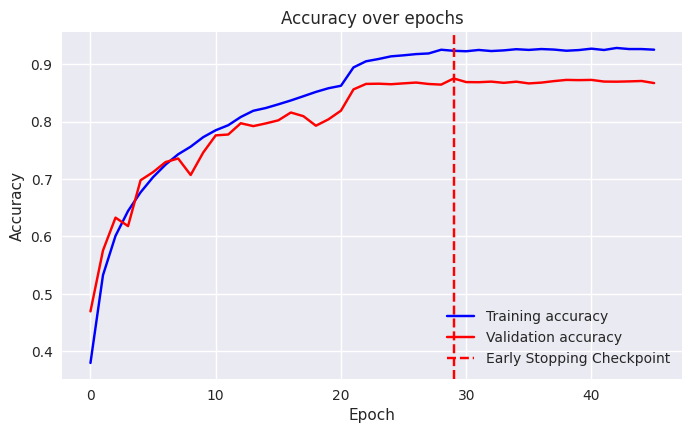

In [20]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'GoogLeNet - predictions')

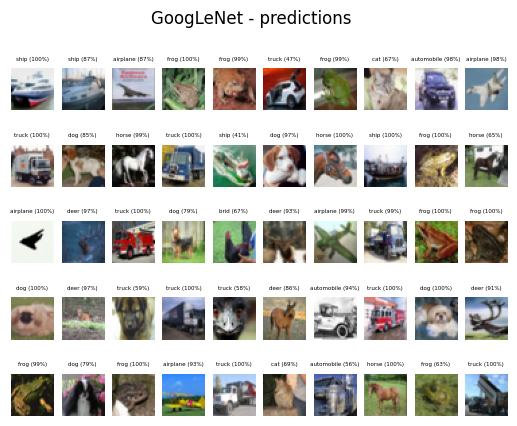

In [21]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('GoogLeNet - predictions')

In [ ]:
"""
GooLeNet
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
        BasicBlock-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10          [-1, 192, 56, 56]         110,784
      BatchNorm2d-11          [-1, 192, 56, 56]             384
             ReLU-12          [-1, 192, 56, 56]               0
       BasicBlock-13          [-1, 192, 56, 56]               0
        MaxPool2d-14          [-1, 192, 28, 28]               0
           Conv2d-15           [-1, 64, 28, 28]          12,352
      BatchNorm2d-16           [-1, 64, 28, 28]             128
             ReLU-17           [-1, 64, 28, 28]               0
       BasicBlock-18           [-1, 64, 28, 28]               0
           Conv2d-19           [-1, 96, 28, 28]          18,528
      BatchNorm2d-20           [-1, 96, 28, 28]             192
             ReLU-21           [-1, 96, 28, 28]               0
       BasicBlock-22           [-1, 96, 28, 28]               0
           Conv2d-23          [-1, 128, 28, 28]         110,720
      BatchNorm2d-24          [-1, 128, 28, 28]             256
             ReLU-25          [-1, 128, 28, 28]               0
       BasicBlock-26          [-1, 128, 28, 28]               0
           Conv2d-27           [-1, 16, 28, 28]           3,088
      BatchNorm2d-28           [-1, 16, 28, 28]              32
             ReLU-29           [-1, 16, 28, 28]               0
       BasicBlock-30           [-1, 16, 28, 28]               0
           Conv2d-31           [-1, 32, 28, 28]          12,832
      BatchNorm2d-32           [-1, 32, 28, 28]              64
             ReLU-33           [-1, 32, 28, 28]               0
       BasicBlock-34           [-1, 32, 28, 28]               0
        MaxPool2d-35          [-1, 192, 28, 28]               0
           Conv2d-36           [-1, 32, 28, 28]           6,176
      BatchNorm2d-37           [-1, 32, 28, 28]              64
             ReLU-38           [-1, 32, 28, 28]               0
       BasicBlock-39           [-1, 32, 28, 28]               0
        Inception-40          [-1, 256, 28, 28]               0
           Conv2d-41          [-1, 128, 28, 28]          32,896
      BatchNorm2d-42          [-1, 128, 28, 28]             256
             ReLU-43          [-1, 128, 28, 28]               0
       BasicBlock-44          [-1, 128, 28, 28]               0
           Conv2d-45          [-1, 128, 28, 28]          32,896
      BatchNorm2d-46          [-1, 128, 28, 28]             256
             ReLU-47          [-1, 128, 28, 28]               0
       BasicBlock-48          [-1, 128, 28, 28]               0
           Conv2d-49          [-1, 192, 28, 28]         221,376
      BatchNorm2d-50          [-1, 192, 28, 28]             384
             ReLU-51          [-1, 192, 28, 28]               0
       BasicBlock-52          [-1, 192, 28, 28]               0
           Conv2d-53           [-1, 32, 28, 28]           8,224
      BatchNorm2d-54           [-1, 32, 28, 28]              64
             ReLU-55           [-1, 32, 28, 28]               0
       BasicBlock-56           [-1, 32, 28, 28]               0
           Conv2d-57           [-1, 96, 28, 28]          76,896
      BatchNorm2d-58           [-1, 96, 28, 28]             192
             ReLU-59           [-1, 96, 28, 28]               0
       BasicBlock-60           [-1, 96, 28, 28]               0
        MaxPool2d-61          [-1, 256, 28, 28]               0
           Conv2d-62           [-1, 64, 28, 28]          16,448
      BatchNorm2d-63           [-1, 64, 28, 28]             128
             ReLU-64           [-1, 64, 28, 28]               0
       BasicBlock-65           [-1, 64, 28, 28]               0
        Inception-66          [-1, 480, 28, 28]               0
        MaxPool2d-67          [-1, 480, 14, 14]               0
           Conv2d-68          [-1, 192, 14, 14]          92,352
      BatchNorm2d-69          [-1, 192, 14, 14]             384
             ReLU-70          [-1, 192, 14, 14]               0
       BasicBlock-71          [-1, 192, 14, 14]               0
           Conv2d-72           [-1, 96, 14, 14]          46,176
      BatchNorm2d-73           [-1, 96, 14, 14]             192
             ReLU-74           [-1, 96, 14, 14]               0
       BasicBlock-75           [-1, 96, 14, 14]               0
           Conv2d-76          [-1, 208, 14, 14]         179,920
      BatchNorm2d-77          [-1, 208, 14, 14]             416
             ReLU-78          [-1, 208, 14, 14]               0
       BasicBlock-79          [-1, 208, 14, 14]               0
           Conv2d-80           [-1, 16, 14, 14]           7,696
      BatchNorm2d-81           [-1, 16, 14, 14]              32
             ReLU-82           [-1, 16, 14, 14]               0
       BasicBlock-83           [-1, 16, 14, 14]               0
           Conv2d-84           [-1, 48, 14, 14]          19,248
      BatchNorm2d-85           [-1, 48, 14, 14]              96
             ReLU-86           [-1, 48, 14, 14]               0
       BasicBlock-87           [-1, 48, 14, 14]               0
        MaxPool2d-88          [-1, 480, 14, 14]               0
           Conv2d-89           [-1, 64, 14, 14]          30,784
      BatchNorm2d-90           [-1, 64, 14, 14]             128
             ReLU-91           [-1, 64, 14, 14]               0
       BasicBlock-92           [-1, 64, 14, 14]               0
        Inception-93          [-1, 512, 14, 14]               0
           Conv2d-94          [-1, 160, 14, 14]          82,080
      BatchNorm2d-95          [-1, 160, 14, 14]             320
             ReLU-96          [-1, 160, 14, 14]               0
       BasicBlock-97          [-1, 160, 14, 14]               0
           Conv2d-98          [-1, 112, 14, 14]          57,456
      BatchNorm2d-99          [-1, 112, 14, 14]             224
            ReLU-100          [-1, 112, 14, 14]               0
      BasicBlock-101          [-1, 112, 14, 14]               0
          Conv2d-102          [-1, 224, 14, 14]         226,016
     BatchNorm2d-103          [-1, 224, 14, 14]             448
            ReLU-104          [-1, 224, 14, 14]               0
      BasicBlock-105          [-1, 224, 14, 14]               0
          Conv2d-106           [-1, 24, 14, 14]          12,312
     BatchNorm2d-107           [-1, 24, 14, 14]              48
            ReLU-108           [-1, 24, 14, 14]               0
      BasicBlock-109           [-1, 24, 14, 14]               0
          Conv2d-110           [-1, 64, 14, 14]          38,464
     BatchNorm2d-111           [-1, 64, 14, 14]             128
            ReLU-112           [-1, 64, 14, 14]               0
      BasicBlock-113           [-1, 64, 14, 14]               0
       MaxPool2d-114          [-1, 512, 14, 14]               0
          Conv2d-115           [-1, 64, 14, 14]          32,832
     BatchNorm2d-116           [-1, 64, 14, 14]             128
            ReLU-117           [-1, 64, 14, 14]               0
      BasicBlock-118           [-1, 64, 14, 14]               0
       Inception-119          [-1, 512, 14, 14]               0
          Conv2d-120          [-1, 128, 14, 14]          65,664
     BatchNorm2d-121          [-1, 128, 14, 14]             256
            ReLU-122          [-1, 128, 14, 14]               0
      BasicBlock-123          [-1, 128, 14, 14]               0
          Conv2d-124          [-1, 128, 14, 14]          65,664
     BatchNorm2d-125          [-1, 128, 14, 14]             256
            ReLU-126          [-1, 128, 14, 14]               0
      BasicBlock-127          [-1, 128, 14, 14]               0
          Conv2d-128          [-1, 256, 14, 14]         295,168
     BatchNorm2d-129          [-1, 256, 14, 14]             512
            ReLU-130          [-1, 256, 14, 14]               0
      BasicBlock-131          [-1, 256, 14, 14]               0
          Conv2d-132           [-1, 24, 14, 14]          12,312
     BatchNorm2d-133           [-1, 24, 14, 14]              48
            ReLU-134           [-1, 24, 14, 14]               0
      BasicBlock-135           [-1, 24, 14, 14]               0
          Conv2d-136           [-1, 64, 14, 14]          38,464
     BatchNorm2d-137           [-1, 64, 14, 14]             128
            ReLU-138           [-1, 64, 14, 14]               0
      BasicBlock-139           [-1, 64, 14, 14]               0
       MaxPool2d-140          [-1, 512, 14, 14]               0
          Conv2d-141           [-1, 64, 14, 14]          32,832
     BatchNorm2d-142           [-1, 64, 14, 14]             128
            ReLU-143           [-1, 64, 14, 14]               0
      BasicBlock-144           [-1, 64, 14, 14]               0
       Inception-145          [-1, 512, 14, 14]               0
          Conv2d-146          [-1, 112, 14, 14]          57,456
     BatchNorm2d-147          [-1, 112, 14, 14]             224
            ReLU-148          [-1, 112, 14, 14]               0
      BasicBlock-149          [-1, 112, 14, 14]               0
          Conv2d-150          [-1, 114, 14, 14]          58,482
     BatchNorm2d-151          [-1, 114, 14, 14]             228
            ReLU-152          [-1, 114, 14, 14]               0
      BasicBlock-153          [-1, 114, 14, 14]               0
          Conv2d-154          [-1, 288, 14, 14]         295,776
     BatchNorm2d-155          [-1, 288, 14, 14]             576
            ReLU-156          [-1, 288, 14, 14]               0
      BasicBlock-157          [-1, 288, 14, 14]               0
          Conv2d-158           [-1, 32, 14, 14]          16,416
     BatchNorm2d-159           [-1, 32, 14, 14]              64
            ReLU-160           [-1, 32, 14, 14]               0
      BasicBlock-161           [-1, 32, 14, 14]               0
          Conv2d-162           [-1, 64, 14, 14]          51,264
     BatchNorm2d-163           [-1, 64, 14, 14]             128
            ReLU-164           [-1, 64, 14, 14]               0
      BasicBlock-165           [-1, 64, 14, 14]               0
       MaxPool2d-166          [-1, 512, 14, 14]               0
          Conv2d-167           [-1, 64, 14, 14]          32,832
     BatchNorm2d-168           [-1, 64, 14, 14]             128
            ReLU-169           [-1, 64, 14, 14]               0
      BasicBlock-170           [-1, 64, 14, 14]               0
       Inception-171          [-1, 528, 14, 14]               0
          Conv2d-172          [-1, 256, 14, 14]         135,424
     BatchNorm2d-173          [-1, 256, 14, 14]             512
            ReLU-174          [-1, 256, 14, 14]               0
      BasicBlock-175          [-1, 256, 14, 14]               0
          Conv2d-176          [-1, 160, 14, 14]          84,640
     BatchNorm2d-177          [-1, 160, 14, 14]             320
            ReLU-178          [-1, 160, 14, 14]               0
      BasicBlock-179          [-1, 160, 14, 14]               0
          Conv2d-180          [-1, 320, 14, 14]         461,120
     BatchNorm2d-181          [-1, 320, 14, 14]             640
            ReLU-182          [-1, 320, 14, 14]               0
      BasicBlock-183          [-1, 320, 14, 14]               0
          Conv2d-184           [-1, 32, 14, 14]          16,928
     BatchNorm2d-185           [-1, 32, 14, 14]              64
            ReLU-186           [-1, 32, 14, 14]               0
      BasicBlock-187           [-1, 32, 14, 14]               0
          Conv2d-188          [-1, 128, 14, 14]         102,528
     BatchNorm2d-189          [-1, 128, 14, 14]             256
            ReLU-190          [-1, 128, 14, 14]               0
      BasicBlock-191          [-1, 128, 14, 14]               0
       MaxPool2d-192          [-1, 528, 14, 14]               0
          Conv2d-193          [-1, 128, 14, 14]          67,712
     BatchNorm2d-194          [-1, 128, 14, 14]             256
            ReLU-195          [-1, 128, 14, 14]               0
      BasicBlock-196          [-1, 128, 14, 14]               0
       Inception-197          [-1, 832, 14, 14]               0
       MaxPool2d-198            [-1, 832, 7, 7]               0
          Conv2d-199            [-1, 256, 7, 7]         213,248
     BatchNorm2d-200            [-1, 256, 7, 7]             512
            ReLU-201            [-1, 256, 7, 7]               0
      BasicBlock-202            [-1, 256, 7, 7]               0
          Conv2d-203            [-1, 160, 7, 7]         133,280
     BatchNorm2d-204            [-1, 160, 7, 7]             320
            ReLU-205            [-1, 160, 7, 7]               0
      BasicBlock-206            [-1, 160, 7, 7]               0
          Conv2d-207            [-1, 320, 7, 7]         461,120
     BatchNorm2d-208            [-1, 320, 7, 7]             640
            ReLU-209            [-1, 320, 7, 7]               0
      BasicBlock-210            [-1, 320, 7, 7]               0
          Conv2d-211             [-1, 32, 7, 7]          26,656
     BatchNorm2d-212             [-1, 32, 7, 7]              64
            ReLU-213             [-1, 32, 7, 7]               0
      BasicBlock-214             [-1, 32, 7, 7]               0
          Conv2d-215            [-1, 128, 7, 7]         102,528
     BatchNorm2d-216            [-1, 128, 7, 7]             256
            ReLU-217            [-1, 128, 7, 7]               0
      BasicBlock-218            [-1, 128, 7, 7]               0
       MaxPool2d-219            [-1, 832, 7, 7]               0
          Conv2d-220            [-1, 128, 7, 7]         106,624
     BatchNorm2d-221            [-1, 128, 7, 7]             256
            ReLU-222            [-1, 128, 7, 7]               0
      BasicBlock-223            [-1, 128, 7, 7]               0
       Inception-224            [-1, 832, 7, 7]               0
          Conv2d-225            [-1, 384, 7, 7]         319,872
     BatchNorm2d-226            [-1, 384, 7, 7]             768
            ReLU-227            [-1, 384, 7, 7]               0
      BasicBlock-228            [-1, 384, 7, 7]               0
          Conv2d-229            [-1, 192, 7, 7]         159,936
     BatchNorm2d-230            [-1, 192, 7, 7]             384
            ReLU-231            [-1, 192, 7, 7]               0
      BasicBlock-232            [-1, 192, 7, 7]               0
          Conv2d-233            [-1, 384, 7, 7]         663,936
     BatchNorm2d-234            [-1, 384, 7, 7]             768
            ReLU-235            [-1, 384, 7, 7]               0
      BasicBlock-236            [-1, 384, 7, 7]               0
          Conv2d-237             [-1, 48, 7, 7]          39,984
     BatchNorm2d-238             [-1, 48, 7, 7]              96
            ReLU-239             [-1, 48, 7, 7]               0
      BasicBlock-240             [-1, 48, 7, 7]               0
          Conv2d-241            [-1, 128, 7, 7]         153,728
     BatchNorm2d-242            [-1, 128, 7, 7]             256
            ReLU-243            [-1, 128, 7, 7]               0
      BasicBlock-244            [-1, 128, 7, 7]               0
       MaxPool2d-245            [-1, 832, 7, 7]               0
          Conv2d-246            [-1, 128, 7, 7]         106,624
     BatchNorm2d-247            [-1, 128, 7, 7]             256
            ReLU-248            [-1, 128, 7, 7]               0
      BasicBlock-249            [-1, 128, 7, 7]               0
       Inception-250           [-1, 1024, 7, 7]               0
AdaptiveAvgPool2d-251           [-1, 1024, 1, 1]               0
         Dropout-252                 [-1, 1024]               0
          Linear-253                   [-1, 10]          10,250
================================================================
Total params: 5,905,152
Trainable params: 5,905,152
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 118.53
Params size (MB): 22.53
Estimated Total Size (MB): 141.63
----------------------------------------------------------------
parameters_count: 5905152
"""